# AGL Autoencoder

Based on https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import copy
import itertools

import data

Seed for reproducability

In [15]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Grammar

In [16]:
class GrammarGen():
    """
    Generates Grammar sequences from grammars, and offers other functionalities
    Grammars are dictionaries:
    - always have START
    - all paths lead eventually to END
    - Entries starting with the same letter
      have same output
    """

    def __init__(self, grammar=None):
        if grammar is None:
            self.grammar = data.g0()
        else:
            self.grammar = grammar

        # find how many letters in grammar
        self.len = len(set([token[0] for token in self.grammar if (token != 'START' and token != 'END')]))

        # variable to check how many sequences have been generated for the grammaticality test
        self.grammCheckMaxLen = -1

    def __len__(self):
        return self.len

    def generate(self, n):
        """Generates n tokens"""
        ret = []
        count = 0
        hashtrack = set()
        while count < n:
            token = []
            current = 'START'
            while current != 'END':
                # Append current
                if current != 'START':
                    token.append(current[0])
                # Choose next
                r = random.randint(0, len(self.grammar[current]) - 1)
                current = self.grammar[current][r]
            # Check if seq is already inside
            tokenhash = ''.join([str(x) for x in token])
            if tokenhash not in hashtrack:
                hashtrack.add(tokenhash)
                ret.append((token, ))
                count += 1

        return ret

    def generateAllGrammatical(self, maxlen=float('inf')):
        """Generates all grammatical sequences until length maxlen"""
        def genAllHelp(seq, current):
            if current == 'END':
                return [seq]
            if len(seq) >= maxlen:
                return []
            # Append Current
            if current != 'START':
                seq.append(current[0])
            # Generate next possibilities
            options = range(len(self.grammar[current]))
            ret = [(genAllHelp(copy.copy(seq), self.grammar[current][i]))
                   for i in options]
            return itertools.chain(*ret)
        return set([tuple(seq) for seq in genAllHelp([], 'START')])

    def isGrammatical(self, seqs):
        """Check for grammaticality of sequences in seqs"""
        maxlen = max([len(seq) for seq in seqs])
        if self.grammCheckMaxLen < maxlen:
            self.allGrammatical = self.generateAllGrammatical(maxlen)
            self.grammCheckMaxLen = maxlen

        return [tuple(seq) in self.allGrammatical for seq in seqs]

## Data

First, get the training and test sequences.

In [17]:
train_seqs = data.g1_train()
valid_seqs = data.g1_train()
test_seqs = data.g1_test_gr()
test_seqs_ugr = data.g1_test_ugr_balanced()

Set padding, start and end token.

In [18]:
PAD_TOKEN = 0
START_TOKEN = 1
END_TOKEN = 2

Sort the data for better performance

In [19]:
train_seqs.sort(key=(lambda x: len(x)))
valid_seqs.sort(key=(lambda x: len(x)))
test_seqs.sort(key=(lambda x: len(x)))

Build a vocabulary, a mapping from letters to numbers.
Start, end and padding token need to be taken into account, thus the vocabulary starts at 3

In [20]:
letters = set()
for seq in train_seqs:
    [letters.add(letter) for letter in seq]

counter = 3
vocab = {'<pad>': PAD_TOKEN, '<sos>': START_TOKEN, '<eos>': END_TOKEN}
for letter in letters:
    vocab[letter] = counter
    counter +=1

In [21]:
letterToNumbers = lambda seq: [vocab[letter] for letter in seq]

In [22]:
reverse_vocab = {v: k for k, v in vocab.items()}
numbersToLetters = lambda seq: [reverse_vocab[number] for number in seq]

Define a Dataset for Sequences:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [23]:
class SequenceDataset(Dataset):
    """
    Dataset for Sequences
    """

    def __init__(self, seqs):
        """
        Args:
            size (int): amount of sequences generated
        """
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        return self.seqs[idx]

Put data into Datasets

In [24]:
train_ds = SequenceDataset(train_seqs)
valid_ds = SequenceDataset(valid_seqs)
test_ds = SequenceDataset(test_seqs)
test_ds_ugr = SequenceDataset(test_seqs_ugr)

Define collate_batch for the Dataloader: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

Sequences are padded and their non-padded lengths are returned.
Since pack_padded_sequences requires sequences to be sorted, they are sorted too.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    seq_lens = []
    processed_seqs = []
    # Sort in descending order
    batch.sort(reverse=True, key=(lambda x: len(x)))
    # append start and end token
    for seq in batch:
        seq = [START_TOKEN] + letterToNumbers(seq) + [END_TOKEN]
        seq_lens.append(len(seq))
        processed_seqs.append(torch.tensor(seq))
    # pad
    padded_seqs = pad_sequence(processed_seqs)
    seq_lens = torch.tensor(seq_lens)
    return padded_seqs, seq_lens

Put data into Dataloader

In [26]:
BATCH_SIZE = 4

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE,
                     shuffle=False, collate_fn=collate_batch)
test_dl_ugr = DataLoader(test_ds_ugr, batch_size=BATCH_SIZE,
                     shuffle=False, collate_fn=collate_batch)

## Model


### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

T

In [28]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training

In [132]:
INPUT_DIM = max(vocab.values()) + 1
OUTPUT_DIM = max(vocab.values()) + 1
ENC_EMB_DIM = 48
DEC_EMB_DIM = 48
ENC_HID_DIM = 32
DEC_HID_DIM = 32
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001
SRC_PAD_IDX = PAD_TOKEN
PREFIX = "new"

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}"
LOADNAME = "../models/autosave" + title + ".pt"
SAVENAME = "../models/autosave" + title + ".pt"
PLOTSAVE = "../plots/autosave" + title + ".png"

Model paramaeter intialization

In [133]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 48)
    (rnn): GRU(48, 32, bidirectional=True)
    (fc): Linear(in_features=64, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=96, out_features=32, bias=True)
      (v): Linear(in_features=32, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 48)
    (rnn): GRU(112, 32)
    (fc_out): Linear(in_features=144, out_features=8, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Number parameters

In [134]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 36,904 trainable parameters


Optimizer and Loss

In [135]:
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [136]:
TRG_PAD_IDX = PAD_TOKEN

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Training and evaluation functions.

In [137]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch
        trg = src
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [138]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch
            trg = src

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [139]:
def evaluate_extra(model, dataloader, loss_func):

    model.eval()

    loss_total = 0

    with torch.no_grad():
        
        for seq, seq_len in dataloader:

            output = model(seq, seq_len, seq, 0)

            loss = loss_func(output, seq)

            loss_total += loss.item()
        
        if loss_func == allOrNoneLoss:
            return loss_total

        return loss_total / ( len(dataloader) )

def cutEndToken(seq):
    ret = []
    for stim in seq:
        if stim == END_TOKEN:
            break
        ret.append(stim)
    return ret


def allOrNoneLoss(output, trg):
    bs = output.shape[1]
    ret = 0
    pred = output.argmax(-1)[1:]
    trg = trg[1:]
    for b in range(bs):
        p = numbersToLetters(cutEndToken(pred[:,b].tolist()))
        t = numbersToLetters(cutEndToken(trg[:,b].tolist()))
        ret += not p == t
    return torch.tensor(ret)

Timing function

In [140]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

During Training in addition to collecting the train/validation loss, collect the amount of entirely correct predicted sequences on the train and test gr/ugr set.

In [128]:
N_EPOCHS = 1000
CLIP = 1
STEP_SIZE_EVALUATION = 10

best_valid_loss = float('inf')

total_allOrNone = torch.zeros((3, N_EPOCHS//STEP_SIZE_EVALUATION,))
total_loss = torch.zeros((3, N_EPOCHS//STEP_SIZE_EVALUATION,))
# [0,:] = train, [1,:] = test, [2,:] = test_ugr

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_dl, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dl, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), SAVENAME)

    if epoch % STEP_SIZE_EVALUATION == 0:
        idx = epoch//STEP_SIZE_EVALUATION
        total_loss[0,idx] = valid_loss
        total_loss[1,idx] = evaluate(model, test_dl, criterion)
        total_loss[2,idx] = evaluate(model, test_dl_ugr, criterion)
        total_allOrNone[0,idx] = evaluate_extra(model, train_dl, allOrNoneLoss)
        total_allOrNone[1,idx] = evaluate_extra(model, test_dl, allOrNoneLoss)
        total_allOrNone[2,idx] = evaluate_extra(model, test_dl_ugr, allOrNoneLoss)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

   1.031
	 Val. Loss: 0.057 |  Val. PPL:   1.058
Epoch: 811 | Time: 0m 0s
	Train Loss: 0.068 | Train PPL:   1.070
	 Val. Loss: 0.048 |  Val. PPL:   1.050
Epoch: 812 | Time: 0m 0s
	Train Loss: 0.040 | Train PPL:   1.040
	 Val. Loss: 0.048 |  Val. PPL:   1.049
Epoch: 813 | Time: 0m 0s
	Train Loss: 0.027 | Train PPL:   1.027
	 Val. Loss: 0.030 |  Val. PPL:   1.030
Epoch: 814 | Time: 0m 0s
	Train Loss: 0.039 | Train PPL:   1.039
	 Val. Loss: 0.054 |  Val. PPL:   1.056
Epoch: 815 | Time: 0m 0s
	Train Loss: 0.030 | Train PPL:   1.031
	 Val. Loss: 0.049 |  Val. PPL:   1.050
Epoch: 816 | Time: 0m 0s
	Train Loss: 0.041 | Train PPL:   1.042
	 Val. Loss: 0.026 |  Val. PPL:   1.026
Epoch: 817 | Time: 0m 0s
	Train Loss: 0.057 | Train PPL:   1.059
	 Val. Loss: 0.049 |  Val. PPL:   1.050
Epoch: 818 | Time: 0m 0s
	Train Loss: 0.041 | Train PPL:   1.042
	 Val. Loss: 0.052 |  Val. PPL:   1.053
Epoch: 819 | Time: 0m 0s
	Train Loss: 0.050 | Train PPL:   1.052
	 Val. Loss: 0.047 |  Val. PPL:   1.048
Epoch:

Load best model

In [129]:
model.load_state_dict(torch.load(LOADNAME))

test_loss = evaluate(model, test_dl, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.667 | Test PPL:   5.298 |


## Evaluation

In [130]:
def plot_total(total_loss, total_allOrNone):
    figsize = (18,10)
    fig = plt.figure(figsize=figsize)
    xvals = range(0, N_EPOCHS, STEP_SIZE_EVALUATION)
    
    ax1 = fig.add_subplot(211)
    ax1.plot(xvals, total_loss[0,:], label="train", linestyle="-")
    ax1.plot(xvals, total_loss[1,:], label="test", linestyle="--")
    ax1.plot(xvals, total_loss[2,:], label="test_ugr", linestyle="-.")

    ax2 = fig.add_subplot(212)
    ax2.plot(xvals, total_allOrNone[0,:], label="train", linestyle="-")
    ax2.plot(xvals, total_allOrNone[1,:], label="test", linestyle="--")
    ax2.plot(xvals, total_allOrNone[2,:], label="test_ugr", linestyle="-.")

    plt.legend()
    plt.suptitle(title)
    plt.savefig(PLOTSAVE)

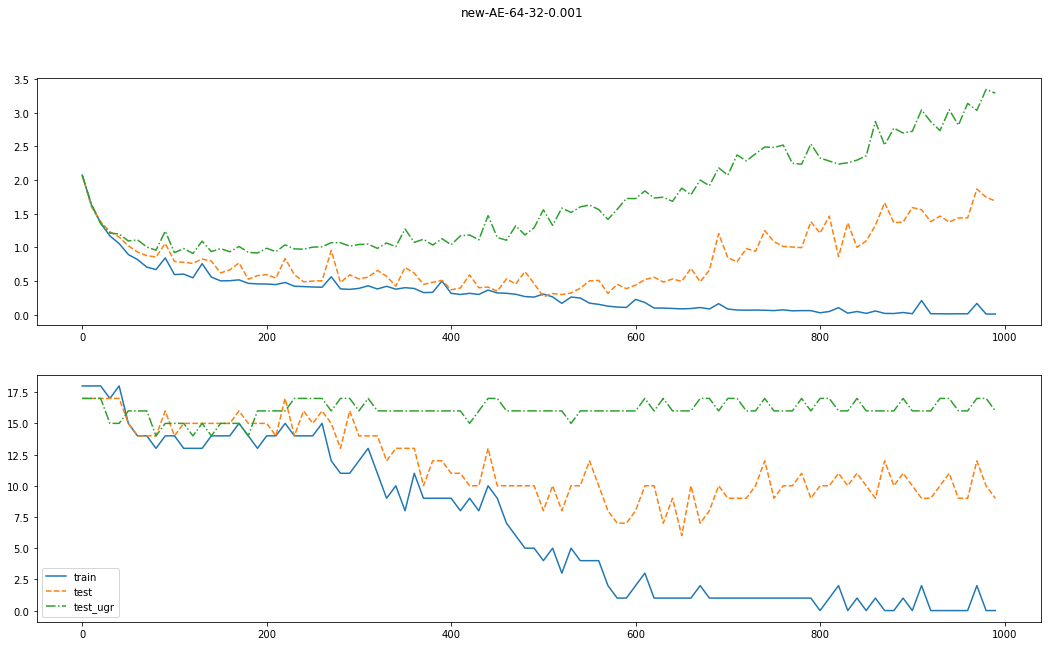

In [131]:
plot_total(total_loss, total_allOrNone)

Some further functions for evuation:

In [78]:
def visual_eval(model, test_dl, ggen=None):

    model.eval()
    
    errors = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(test_dl):

            src, src_len = batch
            trg = src


            output = model(src, src_len, trg, 0) #turn off teacher forcing
            show_batch(output, trg)


def show_batch(output, trg):
    bs = output.shape[1]
    pred = output.argmax(-1)[1:]
    trg = trg[1:]
    for b in range(bs):
        p = numbersToLetters(cutEndToken(pred[:,b].tolist()))
        t = numbersToLetters(cutEndToken(trg[:,b].tolist()))
        status = "same" if p == t else "different"
        print(f"pred = {p} - {status} \ntrg = {t}\n-")
    

Gives a nice overview:

In [79]:
n_error_gr = evaluate_extra(model, test_dl, allOrNoneLoss)
loss_gr = evaluate(model, test_dl, criterion)
n_gr = len(test_seqs)
n_error_ugr = evaluate_extra(model, test_dl_ugr, allOrNoneLoss)
loss_ugr = evaluate(model, test_dl_ugr, criterion)
n_ugr = len(test_seqs_ugr)
print(f"Test gr : {n_error_gr:2}/{n_gr:2} - loss: {loss_gr}")
print(f"Test ugr : {n_error_ugr:2}/{n_ugr:2} - loss: {loss_ugr}")
visual_eval(model, test_dl)

Test gr : 10/17 - loss: 1.508788038790226
Test ugr : 17/17 - loss: 2.325911593437195
pred = ['W', 'W', 'W', 'S', 'N', 'Z'] - different 
trg = ['W', 'W', 'S', 'N', 'P', 'Z']
-
pred = ['N', 'P', 'N', 'Z'] - same 
trg = ['N', 'P', 'N', 'Z']
-
pred = ['N', 'N', 'P', 'Z'] - same 
trg = ['N', 'N', 'P', 'Z']
-
pred = ['W', 'S', 'W', 'S', 'W', 'S', 'W'] - different 
trg = ['W', 'W', 'Z']
-
pred = ['W', 'S', 'W', 'S', 'N', 'P', 'Z'] - same 
trg = ['W', 'S', 'W', 'S', 'N', 'P', 'Z']
-
pred = ['W', 'W', 'S', 'P', 'P', 'N', 'Z'] - same 
trg = ['W', 'W', 'S', 'P', 'P', 'N', 'Z']
-
pred = ['W', 'W', 'S', 'P', 'N', 'Z'] - same 
trg = ['W', 'W', 'S', 'P', 'N', 'Z']
-
pred = ['W', 'S', 'W', 'S', 'N', 'Z'] - same 
trg = ['W', 'S', 'W', 'S', 'N', 'Z']
-
pred = ['W', 'S', 'S', 'W', 'S', 'N', 'P', 'Z'] - same 
trg = ['W', 'S', 'S', 'W', 'S', 'N', 'P', 'Z']
-
pred = ['N', 'N', 'P', 'S', 'P', 'N', 'P', 'Z'] - different 
trg = ['N', 'N', 'P', 'S', 'N', 'P', 'Z']
-
pred = ['N', 'P', 'P', 'N', 'P', 'Z'] - diffe

In [80]:
def predict_sequence(seq, model, device, max_len = 50):

    model.eval()

    src_indexes = [START_TOKEN] + letterToNumbers(seq) + [END_TOKEN]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [START_TOKEN,]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == END_TOKEN:
            break

    trg_tokens = numbersToLetters(trg_indexes)
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Function to display attention

In [86]:
def display_attention(seq, prediction, attention):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t for t in seq] + ['<eos>']
    y_ticks = [''] + prediction
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

#### Train set

seq       = ['W', 'W', 'S', 'N', 'Z']
predicted = ['W', 'W', 'S', 'N', 'Z', '<eos>']
<ipython-input-86-a859c15fffb6>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-86-a859c15fffb6>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


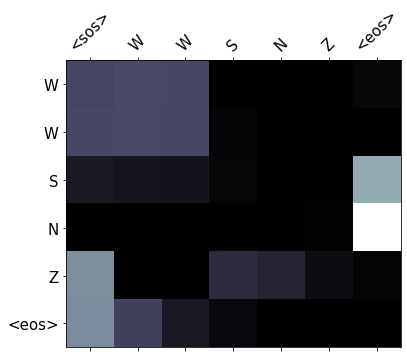

In [87]:
example_idx = 3

seq = train_seqs[example_idx]

print(f'seq       = {seq}')

prediction, attention = predict_sequence(seq, model, device)

print(f'predicted = {prediction}')

display_attention(seq, prediction, attention)

#### Grammatical Testset

seq       = ['W', 'W', 'S', 'N', 'P', 'Z']
predicted = ['W', 'W', 'W', 'S', 'N', 'Z', '<eos>']
<ipython-input-86-a859c15fffb6>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-86-a859c15fffb6>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


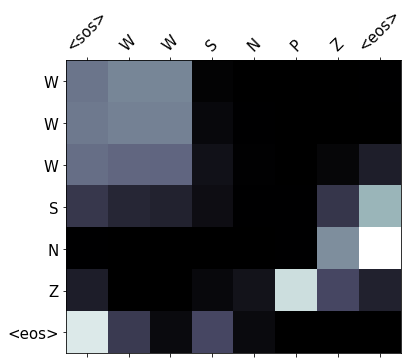

In [88]:
example_idx = 3

seq = test_seqs[example_idx]

print(f'seq       = {seq}')

prediction, attention = predict_sequence(seq, model, device)

print(f'predicted = {prediction}')

display_attention(seq, prediction, attention)

#### Ungrammatical Testset

seq       = ['W', 'S', 'W', 'S', 'Z']
predicted = ['W', 'S', 'W', 'Z', '<eos>']
<ipython-input-86-a859c15fffb6>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-86-a859c15fffb6>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


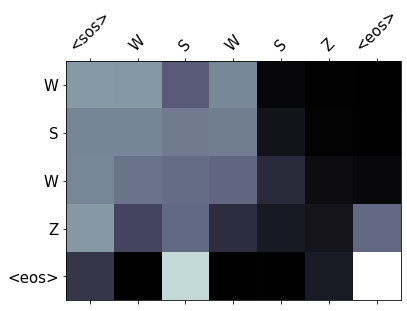

In [90]:
example_idx = 3

seq = test_seqs_ugr[example_idx]

print(f'seq       = {seq}')

prediction, attention = predict_sequence(seq, model, device)

print(f'predicted = {prediction}')

display_attention(seq, prediction, attention)

## Transfer

Reinitialize the weights 